In [30]:
import pandas as pd
import joblib
import json
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def load_config(config_file="../config.json"):
    """Load configuration from a JSON file."""
    with open(config_file, 'r') as file:
        config = json.load(file)
    return config

In [14]:
test_df = pd.read_csv('../outputs/test_df.csv')

In [15]:
test_df.columns

Index(['projectid', 'teacher_referred_count',
       'total_price_excluding_optional_support', 'students_reached',
       'fully_funded', 'date_posted', 'total_projects_in_city',
       'total_projects_in_state', 'poverty_level_high poverty',
       'poverty_level_highest poverty', 'poverty_level_low poverty',
       'poverty_level_moderate poverty', 'school_metro_rural',
       'school_metro_suburban', 'school_metro_urban', 'grade_level_Grades 3-5',
       'grade_level_Grades 6-8', 'grade_level_Grades 9-12',
       'grade_level_Grades PreK-2', 'primary_focus_subject_Applied Sciences',
       'primary_focus_subject_Character Education',
       'primary_focus_subject_Civics & Government',
       'primary_focus_subject_College & Career Prep',
       'primary_focus_subject_Community Service', 'primary_focus_subject_ESL',
       'primary_focus_subject_Early Development',
       'primary_focus_subject_Economics',
       'primary_focus_subject_Environmental Science',
       'primary_focus_su

In [16]:
test_df['date_posted'] = pd.to_datetime(test_df['date_posted'])

In [17]:
# Set max_date to filter projects posted for at least 3 months
fixed_max_date = pd.to_datetime('2013-12-31')
test_df['months_since_posted'] = ((fixed_max_date - test_df['date_posted']) / pd.Timedelta(days=30)).astype(int)
eligible_projects = test_df[test_df['months_since_posted'] >= 3].copy()

In [26]:
test_df

,projectid,teacher_referred_count,total_price_excluding_optional_support,students_reached,fully_funded,date_posted,total_projects_in_city,total_projects_in_state,poverty_level_high poverty,poverty_level_highest poverty,...,primary_focus_subject_Special Needs,primary_focus_subject_Sports,primary_focus_subject_Visual Arts,resource_type_Books,resource_type_Other,resource_type_Supplies,resource_type_Technology,resource_type_Trips,resource_type_Visitors,months_since_posted
0,a11d5c86692ef20e9f702094504bb5db,0.0,387.13,34.0,1.0,2013-01-01,290,126242,False,False,...,False,False,False,False,False,True,False,False,False,12
1,8bdc6b4cfc850f6f7cc3963c48ba454b,0.0,1045.00,120.0,0.0,2013-01-01,172,2127,False,True,...,False,False,False,False,False,False,False,False,True,12
2,88f263f1cd657bccce254ffc0b79df4d,2.0,868.02,28.0,1.0,2013-01-01,102,126242,True,False,...,False,False,False,False,False,True,False,False,False,12
3,a8a6e08b6ae7ab1a88c16ba82ac8e9da,0.0,515.00,96.0,1.0,2013-01-01,206,14853,False,True,...,False,False,False,False,True,False,False,False,False,12
4,be21151602e4fd47dd4012114fd519c6,0.0,238.56,25.0,1.0,2013-01-01,337,18615,False,True,...,False,False,False,False,False,True,False,False,False,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114032,a0e839f24645e3d6dcbd327f8441b043,0.0,567.18,60.0,1.0,2013-12-31,20364,73182,False,True,...,False,False,True,False,False,True,False,False,False,0
114033,f820ef3537f4445b0716244fae36f763,0.0,277.37,30.0,0.0,2013-12-31,55,2030,True,False,...,False,False,False,True,False,False,False,False,False,0
114034,95ee208a51831edffa7cc2e0aa3e83cd,0.0,202.34,98.0,1.0,2013-12-31,2945,9837,False,True,...,False,False,False,True,False,False,False,False,False,0
114035,1aa5e1d739a40c2763da1a0bb0f0f335,2.0,177.18,23.0,1.0,2013-12-31,855,17299,False,True,...,False,False,False,False,False,False,True,False,False,0


In [37]:
config = load_config()
poverty_levels = ["low", "moderate", "high", "highest"]
models = ["random_forest", "logistic_regression"]
recommendations = {}

In [50]:
recommendations = {}

poverty_levels = ["low", "moderate", "high", "highest"]
models = ["random_forest", "logistic_regression"]

for model_type in models:
    for pov_level in poverty_levels:
        pov_column = f"poverty_level_{pov_level} poverty"
        pov_projects = eligible_projects[eligible_projects[pov_column] == 1].copy()
        
        # Load the classifier
        classifier = joblib.load(f"../outputs/{model_type}_{pov_level}_poverty.pkl")
        
        X_test_filtered = pov_projects.drop(columns=['fully_funded', 'date_posted', 'months_since_posted', 'projectid'], errors='ignore')
        X_test_filtered = X_test_filtered.reindex(columns=classifier.feature_names_in_, fill_value=0)
        
        pov_projects[f'probability_fully_funded_{model_type}'] = classifier.predict_proba(X_test_filtered)[:, 1]
        
        pov_projects_sorted = pov_projects.sort_values(by=f'probability_fully_funded_{model_type}', ascending=False)

        if pov_level in ["high", "highest"]:
            top_recommendations = pov_projects_sorted.head(10)
        elif pov_level in ["low", "moderate"]:
            top_recommendations = pov_projects_sorted.head(3)

        recommendations[(model_type, pov_level)] = top_recommendations[['projectid', 'date_posted', f'probability_fully_funded_{model_type}']]

In [51]:
list(recommendations.keys())

[('random_forest', 'low'),
 ('random_forest', 'moderate'),
 ('random_forest', 'high'),
 ('random_forest', 'highest'),
 ('logistic_regression', 'low'),
 ('logistic_regression', 'moderate'),
 ('logistic_regression', 'high'),
 ('logistic_regression', 'highest')]

In [61]:
for key, recs in recommendations.items():
    model_type, pov_level = key  # Unpack manually
    # print(f"\nTop recommendations for {model_type.capitalize()} model, poverty level '{pov_level}':")
    display(key, recs)

('random_forest', 'low')

,projectid,date_posted,probability_fully_funded_random_forest,Model,Poverty Level
72437,f4064b13c27c1fbdc31b151719ba9f08,2013-09-25,1.0,Random_forest,Low
14699,4d2509f0f54df77ab927609b49749094,2013-03-01,1.0,Random_forest,Low
24210,71de20531b97210cbe5f1fa8d9c6c148,2013-04-19,1.0,Random_forest,Low


('random_forest', 'moderate')

,projectid,date_posted,probability_fully_funded_random_forest,Model,Poverty Level
54870,b736a74ca2c9b8a6cc8d1d9ee1e4c2b2,2013-08-25,1.0,Random_forest,Moderate
68404,8e4065284366cb9f7911e4f72de60add,2013-09-17,1.0,Random_forest,Moderate
33098,7cec345ecf8bbf5457449a501ee97b88,2013-06-08,1.0,Random_forest,Moderate


('random_forest', 'high')

,projectid,date_posted,probability_fully_funded_random_forest,Model,Poverty Level
16897,f5c1c43b25747deee09bdc0df6852e15,2013-03-09,1.0,Random_forest,High
4744,fc00aeeb883f2e406d20a3d318311204,2013-01-22,1.0,Random_forest,High
56225,21463e8eb4162599733b866fd63e8330,2013-08-29,1.0,Random_forest,High
5738,b122b0f1e82589ae076eefcb05dfdac5,2013-01-26,1.0,Random_forest,High
52032,a073eb5fcf7d7df4e62a48683c986de9,2013-08-19,1.0,Random_forest,High
5549,343c4906f8ba5149ab919206939030bc,2013-01-25,1.0,Random_forest,High
5472,1afb141002c832acfdde7e95047056f3,2013-01-25,1.0,Random_forest,High
61031,b93d387e199d6580803e7c57e2fa8da1,2013-09-04,1.0,Random_forest,High
52767,20e5fa11b99a27e6afd86beff29bca67,2013-08-21,1.0,Random_forest,High
39097,ed59d86f60de5f62bf58f2839d470062,2013-07-07,1.0,Random_forest,High


('random_forest', 'highest')

,projectid,date_posted,probability_fully_funded_random_forest,Model,Poverty Level
34044,924524717941a48039f1669e1ed75a45,2013-06-13,1.0,Random_forest,Highest
24567,a9b321ce37334e4a51d326ea6bd837cf,2013-04-21,1.0,Random_forest,Highest
6326,d6a288c45dc6137097dd0a599bdfb797,2013-01-27,1.0,Random_forest,Highest
73355,b6b9c69899f58e216fe5c2bb09be2696,2013-09-27,1.0,Random_forest,Highest
6348,49ca3027ed636f35dc2278d51865b96e,2013-01-27,1.0,Random_forest,Highest
17826,e20c432e34d240c658a9199e4b84f9be,2013-03-14,1.0,Random_forest,Highest
46175,90baf355397c227003d45df0b1019a7f,2013-08-05,1.0,Random_forest,Highest
24562,a54842e48e93677e350fcbc1350ae98a,2013-04-21,1.0,Random_forest,Highest
46184,222abfb6618b575f88768f423a3b2ea8,2013-08-05,1.0,Random_forest,Highest
6367,cb9931e5beb6f1279022e684bfb488e6,2013-01-27,1.0,Random_forest,Highest


('logistic_regression', 'low')

,projectid,date_posted,probability_fully_funded_logistic_regression,Model,Poverty Level
9079,b00faec78dcbf574752354bd418b9448,2013-02-08,1.000000,Logistic_regression,Low
71056,9e7ab5c57e54e4c4e6d75e86c7e71a1f,2013-09-22,1.000000,Logistic_regression,Low
67342,469d2fc9421faf51530fcf25c80c154d,2013-09-15,0.999478,Logistic_regression,Low


('logistic_regression', 'moderate')

,projectid,date_posted,probability_fully_funded_logistic_regression,Model,Poverty Level
9200,eccaded79e062ee44c74f229a5f71367,2013-02-09,1.0,Logistic_regression,Moderate
8674,55a8875e022b4cdab5d12ad81231696a,2013-02-07,1.0,Logistic_regression,Moderate
36806,bb481f89c2caf2558fc219d41f328931,2013-06-27,1.0,Logistic_regression,Moderate


('logistic_regression', 'high')

,projectid,date_posted,probability_fully_funded_logistic_regression,Model,Poverty Level
62786,60b5e96c664651ed0f46a6f9c3a164cb,2013-09-07,1.0,Logistic_regression,High
64221,16137012e6bb28e5f2675a13778f6fdd,2013-09-09,1.0,Logistic_regression,High
15548,d696d7a8a4654156a2fac41c6fbd72b1,2013-03-04,1.0,Logistic_regression,High
7026,63783da406806d5025e539b58b10a1b7,2013-01-31,1.0,Logistic_regression,High
10150,71ad58a7eccf5c3ac402f8e06d9965cb,2013-02-11,1.0,Logistic_regression,High
6938,8d6fdceaf067517eb2e446c5036a5134,2013-01-29,1.0,Logistic_regression,High
72319,f71b0045e9861618c587caf94211d2b7,2013-09-25,1.0,Logistic_regression,High
60075,61b0b7269de78fe9375ace64e2e53004,2013-09-03,1.0,Logistic_regression,High
49680,26a46ded38b21614030ef8abe40d4879,2013-08-13,1.0,Logistic_regression,High
11724,dea5ebd7921e9433a9b418c4cd35d884,2013-02-15,1.0,Logistic_regression,High


('logistic_regression', 'highest')

,projectid,date_posted,probability_fully_funded_logistic_regression,Model,Poverty Level
24288,35945268966f1c97ef091d943ddf15f9,2013-04-19,0.777195,Logistic_regression,Highest
27144,87bb2dacd8d43a84f2a4160b00d2615f,2013-05-06,0.777060,Logistic_regression,Highest
23098,55f36bf7347af7c4d9c93bb0c56a4ae2,2013-04-13,0.777050,Logistic_regression,Highest
6,0b2a1dfb1fb9b45fa473a525d81b5d58,2013-01-01,0.776668,Logistic_regression,Highest
9096,5a92f3e1f3ce98cbcefe9ec829fd5d17,2013-02-08,0.776583,Logistic_regression,Highest
42016,8f9b2542712dfe7fe51be67d331d2438,2013-07-21,0.776501,Logistic_regression,Highest
23520,5144b1e86585cef363a24e24590004a7,2013-04-14,0.776456,Logistic_regression,Highest
53759,9fbc5b978062ad84c2f9967f99366854,2013-08-23,0.776431,Logistic_regression,Highest
59673,f48bc6277416f8138df2b58d874b1a15,2013-09-03,0.776406,Logistic_regression,Highest
69385,b0f6fc8f51cb235a42a71e649983db60,2013-09-19,0.776404,Logistic_regression,Highest


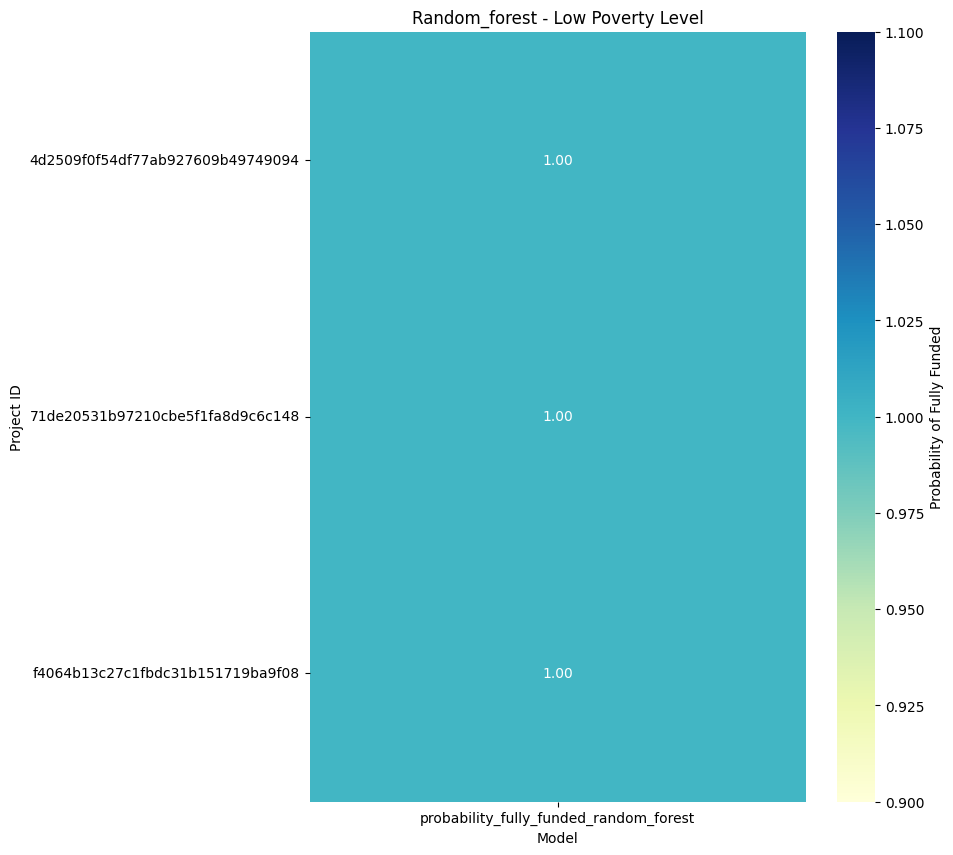

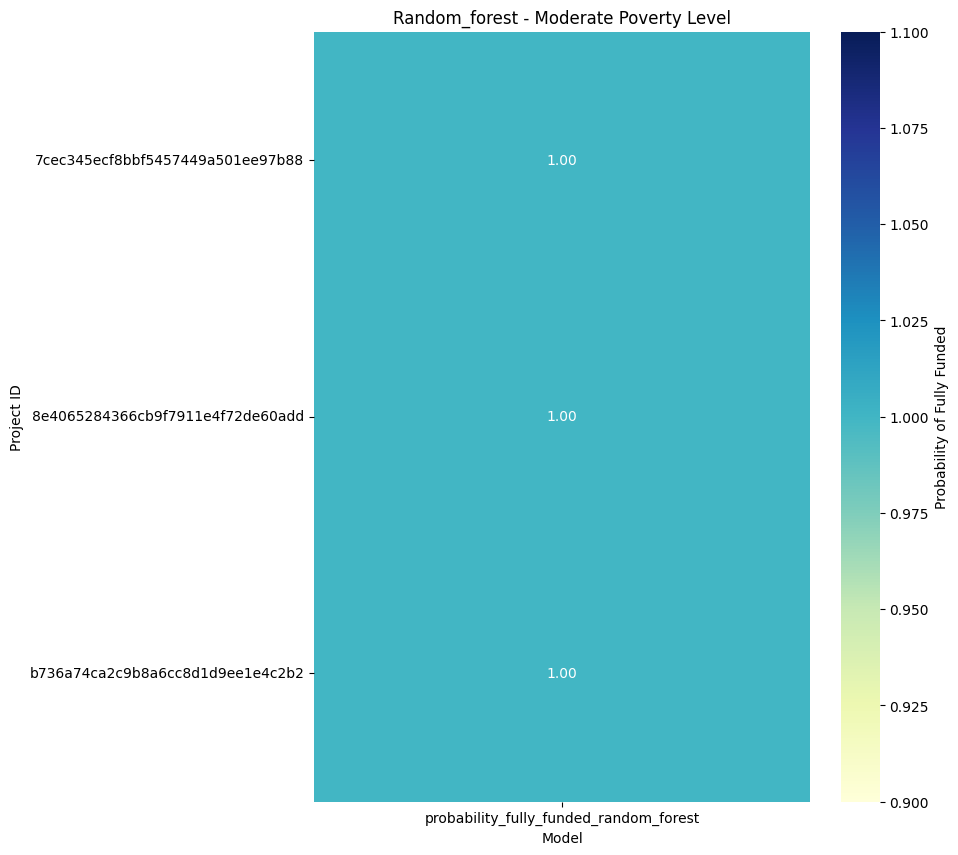

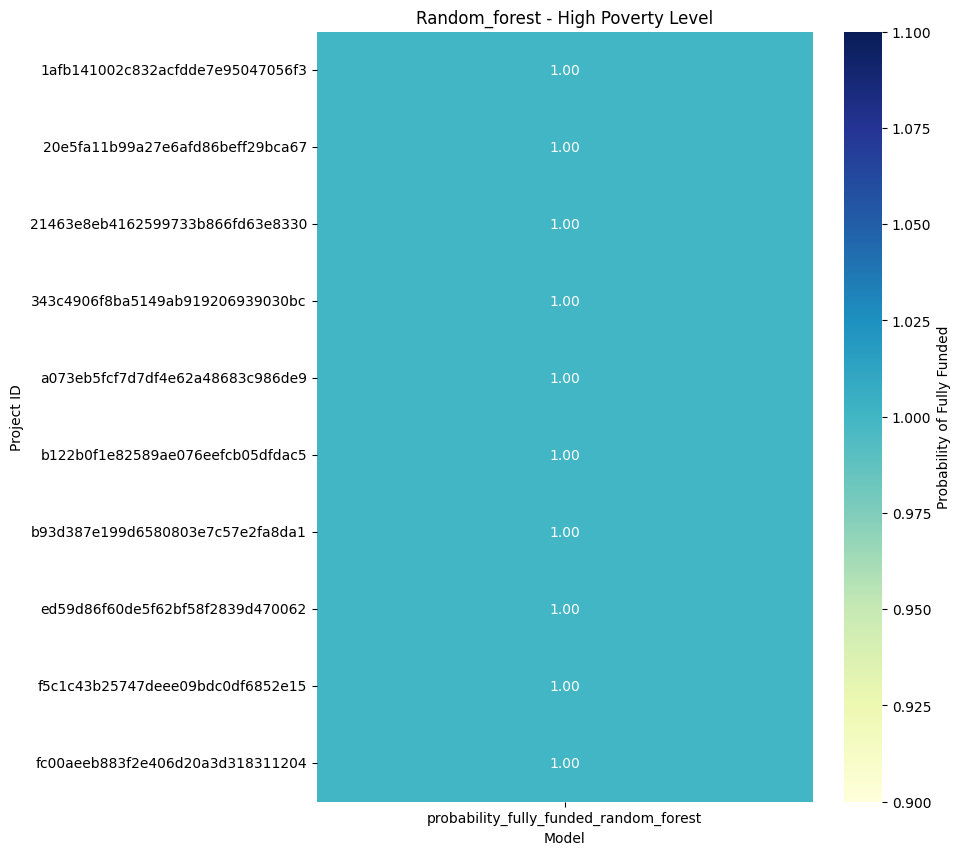

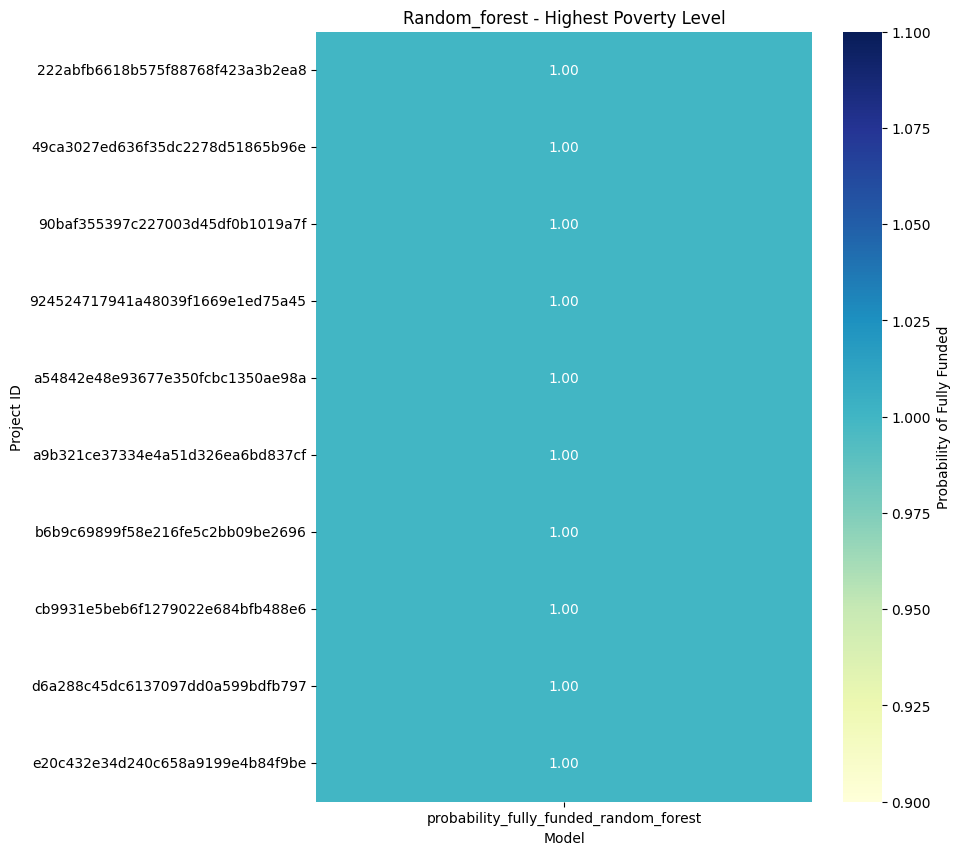

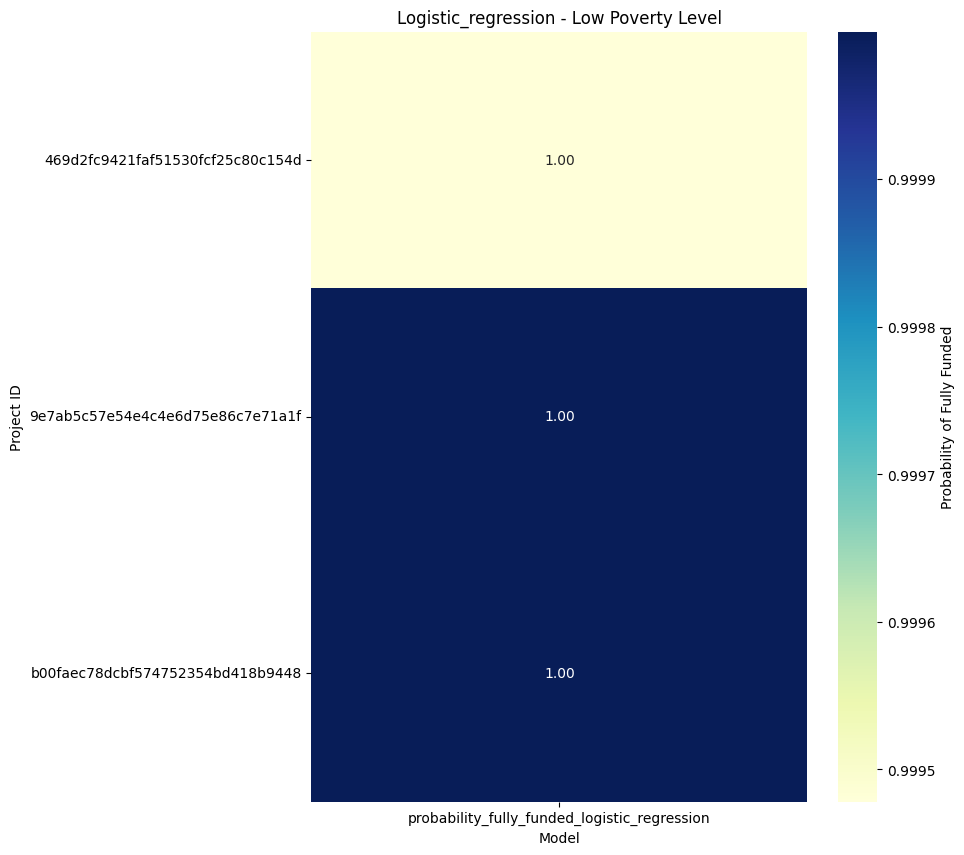

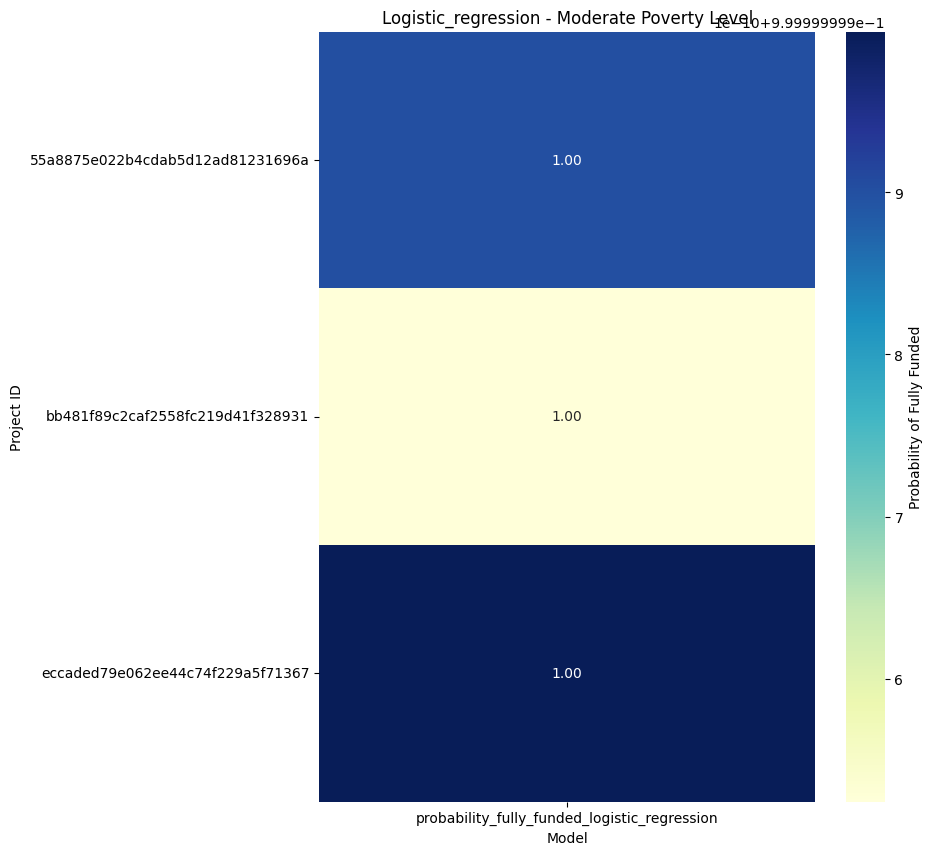

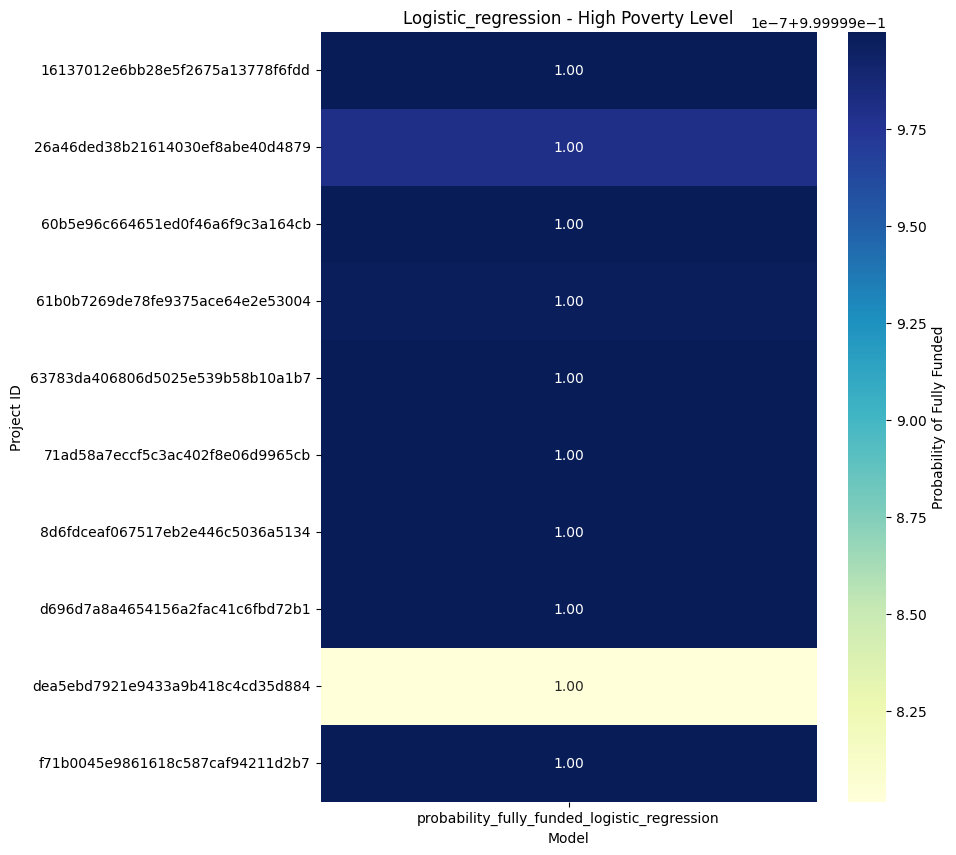

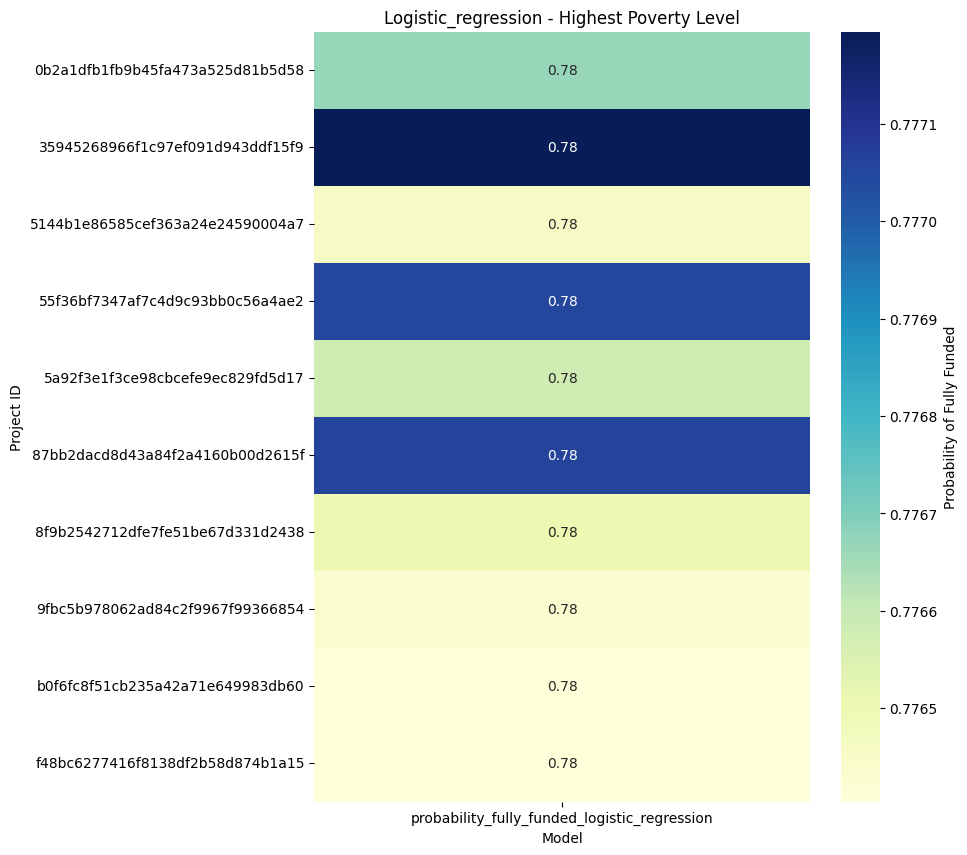

In [65]:
for key, recs in recommendations.items():
    model_type, pov_level = key 

    heatmap_data = recs.pivot_table(
        index='projectid',
        values=f'probability_fully_funded_{model_type}', 
        aggfunc='mean'
    )
    
    plt.figure(figsize=(8, 10))
    sns.heatmap(
        heatmap_data, annot=True, cmap="YlGnBu", fmt=".2f",
        cbar_kws={'label': 'Probability of Fully Funded'}
    )
    plt.title(f"{model_type.capitalize()} - {pov_level.capitalize()} Poverty Level")
    plt.xlabel("Model")
    plt.ylabel("Project ID")
    
    plt.savefig("../outputs/{model_type}_{pov_level}_poverty_level_heatmap.png", dpi=300, bbox_inches="tight")